<a href="https://colab.research.google.com/github/heehminh/SkinHelper-CNN/blob/main/skin_helper_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")


CUDA is available.
Using CUDA device: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# 2. Import Data

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/archive/hmnist_28_28_RGB.csv')

In [ ]:
y = data['label']
x = data.drop(columns = ['label'])

In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


# 3. Exploratory Data Analysis (EDA)

In [ ]:
tabular_data = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
classes = {
    4: ('nv', ' melanocytic nevi'),
    6: ('mel', 'melanoma'),
    2 :('bkl', 'benign keratosis-like lesions'),
    1:('bcc' , ' basal cell carcinoma'),
    5: ('vasc', ' pyogenic granulomas and hemorrhage'),
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    3: ('df', 'dermatofibroma')
}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

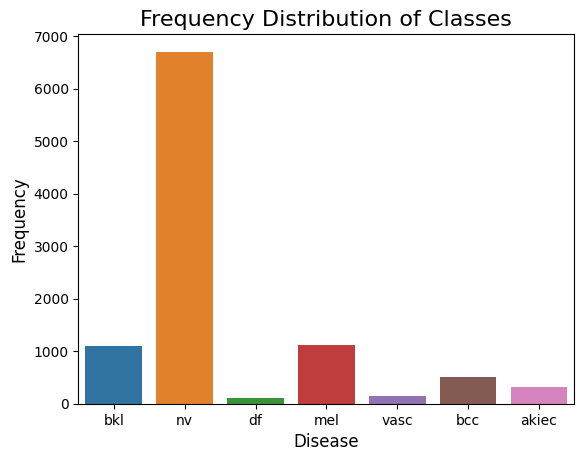

In [ ]:
"""Frequency Distribution of Classes"""

sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# 4. Oversampling

In [ ]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [ ]:
import scipy.ndimage

In [ ]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [ ]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 32, 32, 3)


In [ ]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# 5. Model Training

In [ ]:
vgg=tf.keras.applications.VGG16(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    vgg,
    # tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


In [ ]:
# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.summary()

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1
)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 300,
                    callbacks=[callback])

Epoch 1/300
233/235 [============================>.] - ETA: 0s - loss: 0.5577 - accuracy: 0.8014
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 8s 29ms/step - loss: 0.5578 - accuracy: 0.8014 - val_loss: 0.5774 - val_accuracy: 0.7980
Epoch 2/300
  1/235 [..............................] - ETA: 5s - loss: 0.5862 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.8029
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 6s 25ms/step - loss: 0.5529 - accuracy: 0.8029 - val_loss: 0.5739 - val_accuracy: 0.7972
Epoch 3/300
232/235 [============================>.] - ETA: 0s - loss: 0.5495 - accuracy: 0.8043
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.5499 - accuracy: 0.8038 - val_loss: 0.5780 - val_accuracy: 0.7972
Epoch 4/300
233/235 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.8050
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 5s 23ms/step - loss: 0.5472 - accuracy: 0.8052 - val_loss: 0.5720 - val_accuracy: 0.7997
Epoch 5/300
235/235 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.8076
Epoch 5: saving model to best_model.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.5442 -

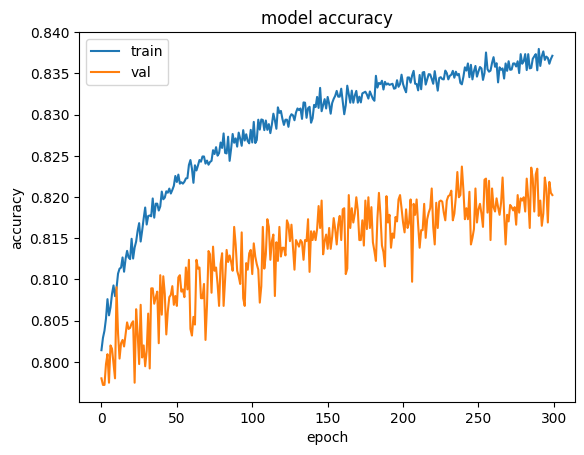

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

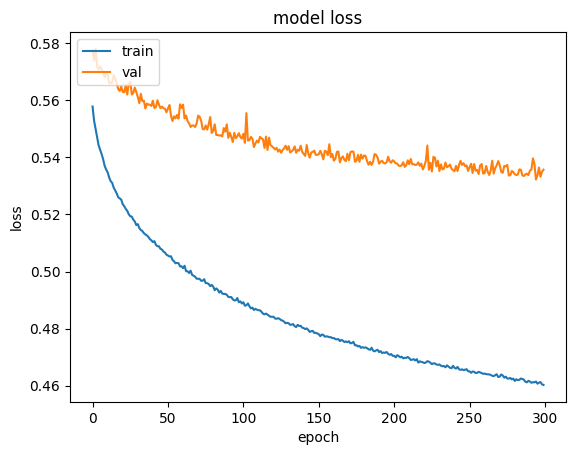

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.h5')

# 6. Model Testing

In [ ]:
loss, acc = model.evaluate(X_train, Y_train, verbose=2)

1174/1174 - 9s - loss: 0.4729 - accuracy: 0.8342 - 9s/epoch - 8ms/step


In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 2s - loss: 0.5382 - accuracy: 0.8192 - 2s/epoch - 7ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 2s 7ms/step


In [ ]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.77      0.92      0.84      1359
         bcc       0.80      0.82      0.81      1318
         bkl       0.69      0.61      0.65      1262
          df       0.96      1.00      0.98      1351
          nv       0.79      0.70      0.74      1374
        vasc       0.99      1.00      1.00      1358
         mel       0.70      0.67      0.68      1365

    accuracy                           0.82      9387
   macro avg       0.82      0.82      0.81      9387
weighted avg       0.82      0.82      0.82      9387



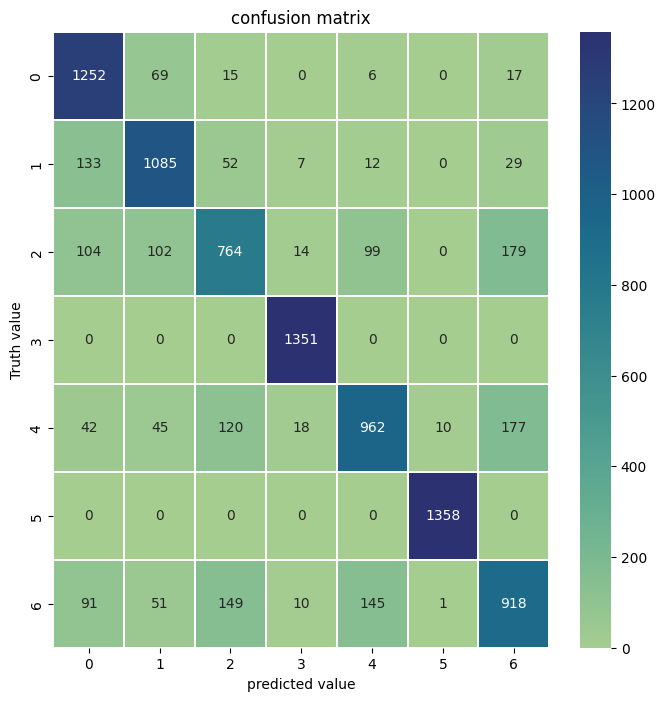

[[1252   69   15    0    6    0   17]
 [ 133 1085   52    7   12    0   29]
 [ 104  102  764   14   99    0  179]
 [   0    0    0 1351    0    0    0]
 [  42   45  120   18  962   10  177]
 [   0    0    0    0    0 1358    0]
 [  91   51  149   10  145    1  918]]


In [ ]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

# 7. Prediction

In [ ]:
classes = {
    4: ('nv', ' melanocytic nevi'), # 흑색증식성 모반
    6: ('mel', 'melanoma'), # 흑색종
    2 :('bkl', 'benign keratosis-like lesions'), # 양성 각질 유사 병변
    1:('bcc' , ' basal cell carcinoma'), # 기저세포암
    5: ('vasc', ' pyogenic granulomas and hemorrhage'), # 혈관성 병변
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'), # 햇빛에 의한 각화증
    3: ('df', 'dermatofibroma') # 피부섬유종
}

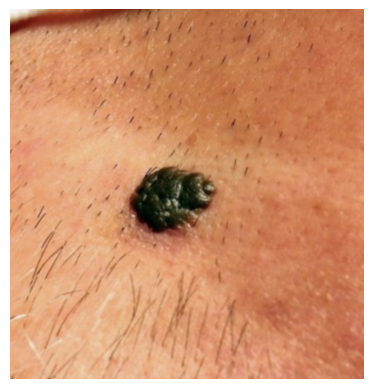

1/1 [==============================] - 0s 132ms/step
Model Prediction: [[0. 0. 0. 0. 0. 0. 1.]]
Top-1 Prediction:
Class: mel, Description: melanoma, Probability: 1.0000


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

# 모델 로드
model_path = '/content/drive/MyDrive/skin-helper-cnn/best_model.h5'
model = load_model(model_path)

# 이미지 로드
image_path = '/content/drive/MyDrive/흑색종.png'
image = cv2.imread(image_path)
image = cv2.resize(image, (32, 32))  # 모델에 맞는 크기로 조정
image = np.expand_dims(image, axis=0)  # 배치 차원 추가

# 이미지 출력
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 모델 예측 (각 class의 확률)
prediction = model.predict(image)

# 예측 결과 출력
print("Model Prediction:", prediction)

# Top-1 예측
top1_class = np.argmax(prediction)
top1_label, top1_description = classes[top1_class]
top1_prob = prediction[0, top1_class]

# 출력
print("Top-1 Prediction:")
print(f"Class: {top1_label}, Description: {top1_description}, Probability: {top1_prob:.4f}")
